In [1]:
# DataFrames and Math
import pandas as pd
import numpy as np
import tqdm
pd.options.display.max_columns = 100

# API management
import json
import base64
import requests
from getpass import getpass

# Plotting
import matplotlib.pyplot as plt

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, PercentFormatter)
import matplotlib.dates as mdates
import matplotlib.patches as patches

# Paths
import pathlib
data_path = path = pathlib.Path().resolve().parent.parent/ "rn_home" / "data"
data_output_path = data_path / "advan_data"
footfall_output_path =  data_path / "advan_data_footfall"
processed_output_path = data_path  / "advan_data_processed"

# Define required functions

In [2]:
def gen_od_matrix_long(input_data, output_filepath = None, filename = None, save = False):
    # Create blank OD Matrix
    od_matrix_thousands = pd.DataFrame([])
    od_matrix_long = pd.DataFrame([])

    # Loop through the data
    for index, row in tqdm.tqdm(input_data.iterrows()):
        # Get the area (i.e. the block group)
        destination = str(row["AREA"]).zfill(12)
        date = row["DATE_RANGE_START"]
    
        # These are all the origin destinations
        origins = json.loads(row["DEVICE_HOME_AREAS"])

        # Get the sum from the origins
        origins_sum = np.sum(list(origins.values()))
        num_missing = row["RAW_DEVICE_COUNTS"] - origins_sum
        origins["missing"] = num_missing

        # Scale up the values to get the number of visits, not just the number of devices
        num_visits = row["RAW_STOP_COUNTS"]
        num_devices = row["RAW_DEVICE_COUNTS"]
        ratio = num_visits / num_devices

        # Create DF
        origins_long_df = pd.DataFrame(origins, index = ["device_count"]).T.reset_index()
        origins_long_df.loc[:,"destination"] = destination
        origins_long_df = origins_long_df.rename(columns = {"index" : "origin"})
        origins_long_df.loc[:, "estimated_stops"] = origins_long_df["device_count"] * ratio
        origins_long_df.loc[:, "date"] = date

        # Append
        od_matrix_thousands = pd.concat([od_matrix_thousands, origins_long_df]).reset_index(drop=True)

        # Append
        if (index % 1000 == 0):
            print(f"Concatenating row {index}")
            od_matrix_long = pd.concat([od_matrix_long, od_matrix_thousands]).reset_index(drop=True)
            od_matrix_thousands = pd.DataFrame([])

    # Final Append
    od_matrix_long = pd.concat([od_matrix_long, od_matrix_thousands]).reset_index(drop=True)
    od_matrix_thousands = pd.DataFrame([])
        
    # Save
    if save:
        od_matrix_long.to_csv(output_filepath / filename)
    
    return od_matrix_long

In [3]:
def gen_od_matrix(input_data, output_filepath = None, filename = None, save = False):
    # Create blank OD Matrix
    od_matrix = pd.DataFrame([])

    # Loop through the data
    for index, row in tqdm.tqdm(input_data.iterrows()):
        # Get the area (i.e. the block group)
        destination = str(row["AREA"]).zfill(12)
    
        # These are all the origin destinations
        origins = json.loads(row["DEVICE_HOME_AREAS"])

        # --- NEW: ADDED on 12/11 --- # 
        # Get the sum from the origins
        origins_sum = np.sum(list(origins.values()))
        num_missing = row["RAW_DEVICE_COUNTS"] - origins_sum
        origins["missing"] = num_missing

        # Scale up the values to get the number of visits, not just the number of devices
        num_visits = row["RAW_STOP_COUNTS"]
        num_devices = row["RAW_DEVICE_COUNTS"]
        ratio = num_visits / num_devices

        # --- END NEW --- # 
        # Create DF
        origins_df = pd.DataFrame(origins, index = [destination])
        origins_df = origins_df.iloc[[0], origins_df.columns.isin(ct_bg_codes)].sort_index(axis=1)
        origins_df = origins_df * ratio
        od_matrix = pd.concat([od_matrix, origins_df])

    # Final cleanup
    od_matrix = od_matrix.fillna(0)
    od_matrix = od_matrix.sort_index(axis =1)
    od_matrix = od_matrix.sort_index(axis = 0)

    # Save
    try:
        if save:
            od_matrix.to_csv(output_filepath / filename)
            print("Saved")
    except:
        pass

    return od_matrix

In [4]:
def plot_od_matrix(data, vmin, vmax, cmap, suptitle, index_to_label = None, labeltext = None, **cbar_kw):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size = "7%", pad = "10%")

    im = ax.imshow(data, vmin = vmin, vmax = vmax, cmap = cmap)

    ax.set_xlabel("Origin Block Group")
    ax.set_ylabel("Destination Block Group")
    ax.set_title(suptitle)

    if index_to_label:
        ax.set_xticks([index_to_label])
        ax.yaxis.set_ticks([])
        ax.set_xticklabels([labeltext])
        ax.yaxis.set_ticklabels([])
        ax.axvline(index_to_label, color = 'red')
        ax.axhline(index_to_label, color = 'red')

    cbar = ax.figure.colorbar(im, ax = ax, cax=cax, **cbar_kw)
    
    plt.show()

In [5]:
def prepare_od_forplot(od_matrix, square = False):
    # Get origins and destinations and make them match by shortening get list of origins
    origins = od_matrix.columns.to_list()
    origins = [int(x[1:]) for x in origins]
    
    # Get list of destinations
    destinations = od_matrix.index.to_list()
    
    # Now make them match - i.e only keep rows for which there is a matching column
    od_matrix = od_matrix.loc[origins]
    
    # Now sort it so that the diagonal is correct
    od_matrix.sort_index(axis = 1)
    od_matrix.sort_index(axis = 0)
    
    # Create copy and convert to numpy
    od_matrix_np = od_matrix.copy(deep=True)
    od_matrix_np = od_matrix_np.to_numpy()

    # Make square and make copy with no diagonal
    od_matrix_np = od_matrix_np[0:2583, 0:2583]
    od_matrix_np_nodiag = od_matrix_np.copy()[0:2583, 0:2583]
    np.fill_diagonal(od_matrix_np_nodiag, 0)

    od_matrix_np_pct = od_matrix_np / np.max(od_matrix_np, axis = 1)
    od_matrix_np_pct_nodiag = od_matrix_np_nodiag / np.max(od_matrix_np_nodiag, axis = 1)
    od_matrix_np_pct_nodiag_singlemax = od_matrix_np_nodiag / np.max(od_matrix_np_nodiag)

    return od_matrix_np_pct, od_matrix_np_pct_nodiag

# Create O-D Matrix

## Create scaled O-D matrix

In [2]:
# Import data
input_data =  pd.read_csv(processed_output_path / "ct_advan_data_2018-01-01_110623_2.csv", index_col = [0])

In [34]:
ct_bg_codes = input_data["AREA"].unique()
ct_bg_codes = [str(code) for code in ct_bg_codes]
ct_bg_codes = ['0' + code for code in ct_bg_codes]

In [35]:
od_scaled = gen_od_matrix(input_data)

2585it [00:32, 78.93it/s]


In [41]:
# Get sum of trips
np.sum(np.sum(od_scaled))

15742861.93840753

# 21-22 OD matrix

In [6]:
input_data =  pd.read_csv(processed_output_path / "ct_advan_data_2021-22_121123.csv", index_col = [0])

In [8]:
# long_od = gen_od_matrix_long(input_data, processed_output_path, "ct_long_od_21-22.csv", save=True)
long_od = pd.read_csv(processed_output_path / "ct_long_od_21-22.csv", index_col = [0])

## Generate quick graph for Ken

In [ ]:
for_graph = long_od[(long_od["origin"] == "090033301001") & (long_od["destination"] == "090033301001")]

In [ ]:
for_graph["date_new"] = pd.to_datetime(for_graph["date"])

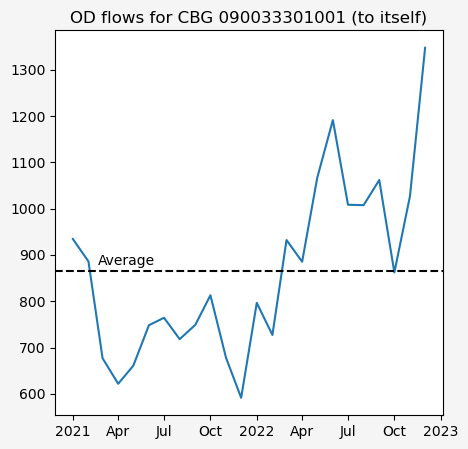

In [58]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5), facecolor = 'whitesmoke')
ax.plot(for_graph["date_new"], for_graph["estimated_stops"], linestyle ='-', label = "Trips between single OD")
ax.set_title("OD flows for CBG 090033301001 (to itself)")
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.axhline(for_graph["estimated_stops"].mean(), linestyle = '--', color = 'black')
ax.text(0.11, 0.39,  "Average", transform=ax.transAxes)
fig.show()

In [7]:
# Get block group codes
ct_bg_codes = input_data["AREA"].astype(str).str.zfill(12).unique().tolist()

In [119]:
long_od["in_ct"] = long_od.apply(lambda x: x.origin in ct_bg_codes, axis = 1)

In [118]:
long_od = long_od.reset_index()

In [48]:
long_od.groupby("destination").count()["origin"].mean()

132.17949709864604

## Create averages

In [ ]:
# Fix desination column
long_od["destination"] = long_od["destination"].astype(str).str.zfill(12)

In [57]:
# Filter only for those origins that are in CT
ct_bgs = long_od["destination"].unique().tolist()
long_od_filtered = long_od.loc[long_od["origin"].isin(ct_bgs),["origin", "destination", "estimated_stops"]]

In [59]:
# Get averages
# Get sum first
long_od_filtered = long_od_filtered.groupby(["origin", "destination"]).mean()

# Fix index
long_od_filtered = long_od_filtered.reset_index()

In [65]:
# Create OD with zeros
od_mat_21_22 = long_od_filtered.pivot(index = "origin", columns = "destination", values = "estimated_stops")
od_mat_21_22.fillna(0, inplace = True)

In [90]:
# Save the new averaged matrix
od_mat_21_22.to_csv(processed_output_path / "od_matrix_21-22_averages.csv")

In [25]:
# Reload
od_mat_21_22 = pd.read_csv(processed_output_path / "od_matrix_21-22_averages.csv", index_col = [0])

## Read in O-D Matrix

In [23]:
# Read in OD Matrix
od_matrix = pd.read_csv(processed_output_path / "od_matrix_110523.csv", index_col =[0])
od_matrix_np = od_matrix.to_numpy()[0:2583, 0:2583]

# Look into diagonal

# Observe highest flows

In [11]:
np.max(od_matrix)

2330.0

In [22]:
od_matrix_np_pct, od_matrix_np_pct_nodiag = prepare_od_forplot(od_matrix, True)

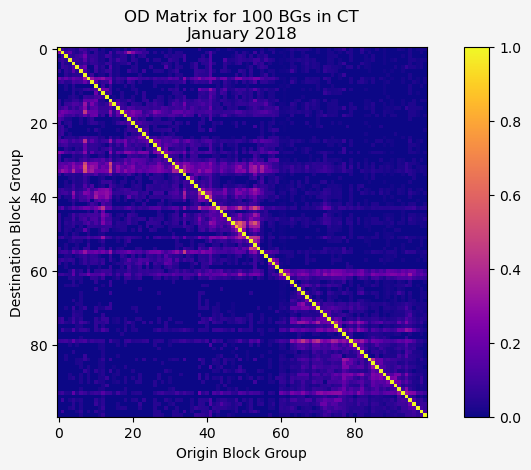

In [9]:
plot_od_matrix(od_matrix_np_pct[0:100, 0:100], 0, 1, 'plasma', 'OD Matrix for 100 BGs in CT\nJanuary 2018')

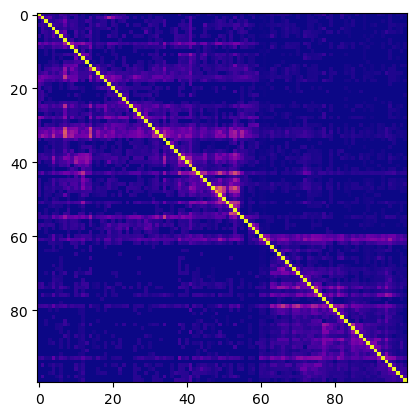

In [11]:
plt.imshow(od_matrix_np_pct[0:100, 0:100], vmin = 0, vmax = 1, cmap = 'plasma')

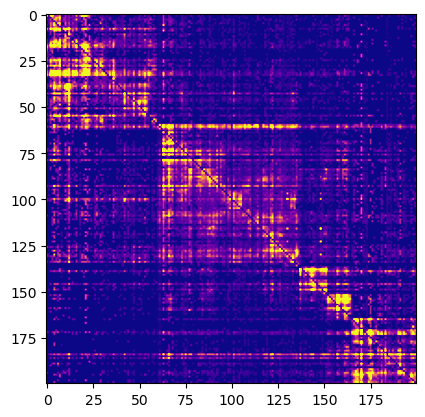

In [12]:
plt.imshow(od_matrix_np_pct_nodiag[0:200, 0:200], vmin = 0, vmax = 1, cmap = 'plasma')

In [68]:
# Get Index of New Haven
od_matrix_blankindex = od_matrix.copy(deep=True).reset_index(drop=False)
od_matrix_blankindex[od_matrix_blankindex["index"]==90091420002].index

Index([1676], dtype='int64')

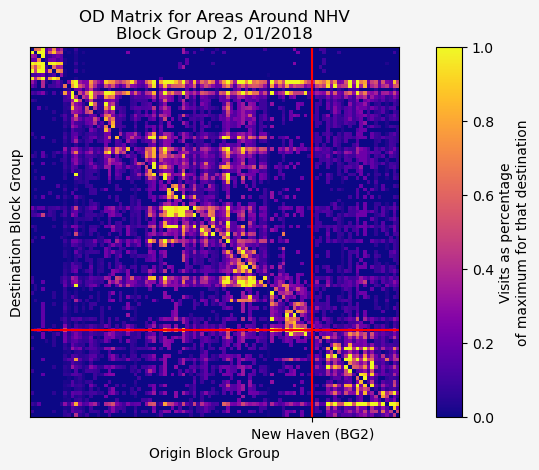

In [13]:
plot_od_matrix(od_matrix_np_pct_nodiag[1600:1700, 1600:1700], 
               0, 1,
               'plasma', 
               'OD Matrix for Areas Around NHV\nBlock Group 2, 01/2018',
               76,
               "New Haven (BG2)",
               label =  "Visits as percentage\nof maximum for that destination")

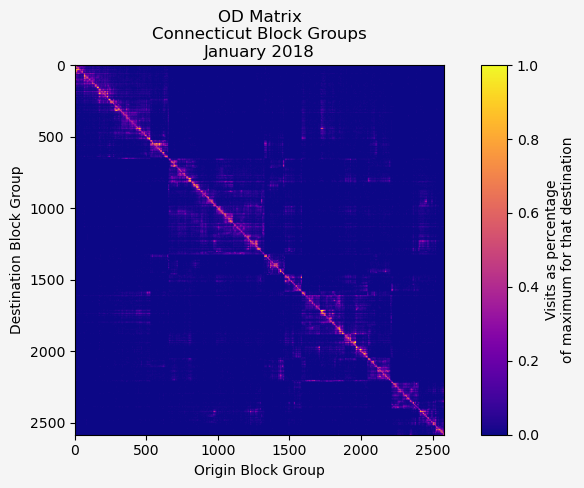

In [150]:
plot_od_matrix(od_matrix_np_pct_nodiag, 
               0, 1,
               'plasma', 
               'OD Matrix\nConnecticut Block Groups\nJanuary 2018',
               label =  "Visits as percentage\nof maximum for that destination")

# Look into area around diagonal

In [2]:
# Read in OD Matrix
# od_matrix = pd.read_csv(processed_output_path / "od_matrix_110523.csv", index_col =[0])
# od_matrix_np = od_matrix.to_numpy()[0:2583, 0:2583]

In [26]:
# Read in new OD matrix
od_matrix = od_mat_21_22
od_matrix_np = od_matrix.to_numpy()[0:2583, 0:2583]

Estimated computing time: 51.96000000000001 hours


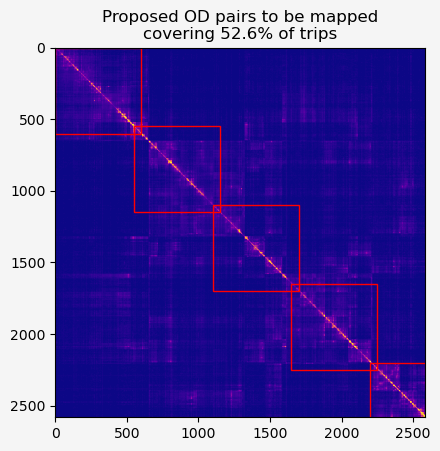

In [57]:
# Get total devices
total_devices = np.sum(od_matrix_np)

# Get the sum around diagonal
# Set up
sum_around_diagonal = 0
size = 600
step = 550
start = 0
end = start + size
side_length = np.shape(od_matrix_np)[0]
print(f"Estimated computing time: {(2582/size * (size**2)) * 8.66/258200} hours")

# Plot it
fig, ax = plt.subplots(nrows = 1, ncols=1, facecolor = 'whitesmoke')
im = ax.imshow(od_matrix, vmin = 0, vmax = 200, cmap = 'plasma')

while (end < side_length):
    sub_mat = od_matrix_np[start:end, start:end]
    add = np.sum(sub_mat)
    subtract = np.sum(sub_mat[0:size-step, 0:size-step]) + np.sum(sub_mat[step:size, step:size])
    sum_around_diagonal += add - subtract
    rect = patches.Rectangle((start, start), size, size, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    start += step
    end = start + size

# Finall addition
sub_mat = od_matrix_np[start:side_length, start:side_length]
rect = patches.Rectangle((start, start), size, size, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
add = np.sum(sub_mat)
subtract = np.sum(sub_mat[0:size-step, 0:size-step]) + np.sum(sub_mat[step:size, step:size])
sum_around_diagonal += add - subtract

# Add title
pct_coverage = sum_around_diagonal * 100 / total_devices
ax.set_title(f"Proposed OD pairs to be mapped\ncovering {pct_coverage:0.1f}% of trips")

# Show
plt.show()

# Extract correct CBGs to map

In [35]:
od_mat_toextract = od_matrix.iloc[0:2582, 0:2582].sort_index(axis=1).sort_index(axis = 0)

In [36]:
start = 0
end = start + size
side_length = 2582
i = 1
master = pd.DataFrame([])
master["CBG"] = od_mat_toextract.index.astype(str).str.zfill(12)

In [37]:
# Extract codes
while (end < side_length):
    # sub_df = od_mat_toextract.iloc[start:end, start:end]
    master[i] = 0
    master.iloc[start:end,i] = 1
    master = master.rename(columns = {i:f"iteration_{i}"})
    start += step
    end = start + size
    i += 1

master[i] = 0
master.iloc[start:side_length,i] = 1
master = master.rename(columns = {i:f"iteration_{i}"})

In [60]:
sum(master["iteration_4"]==1)

482

In [55]:
master.to_csv(processed_output_path / "routes_to_generate.csv")